In [40]:
import os
print(os.getcwd())

c:\Users\Ahmed\Desktop\AdvSecLab\advseceng25-sca-framework-main\src\py


In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
data = np.load(r"C:\Users\Ahmed\Desktop\AdvSecLab\traces\traces_0.npz")
print(data.files)
print(data['wave'].shape)
num_traces = data['wave'].shape[0]
trace_length = data['wave'].shape[1]

print(f"Number of traces: {num_traces}")
print(f"Trace length: {trace_length} samples")

['wave', 'dut_io_data', 'dut_io_computed_data']
(5000, 150)
Number of traces: 5000
Trace length: 150 samples


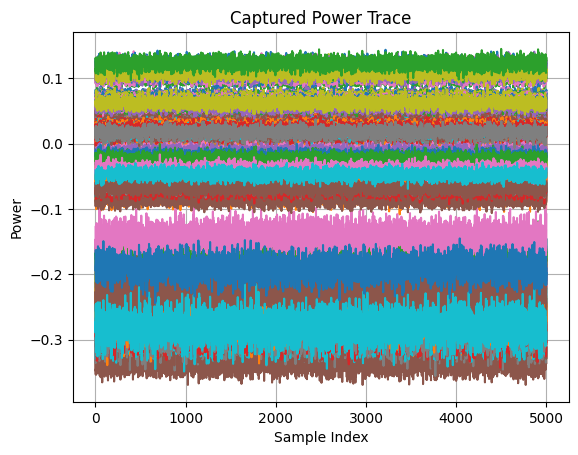

In [43]:
# Example: plot the waveform
waveform = data['wave']
plt.plot(waveform)
plt.title("Captured Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.grid(True)
plt.show()

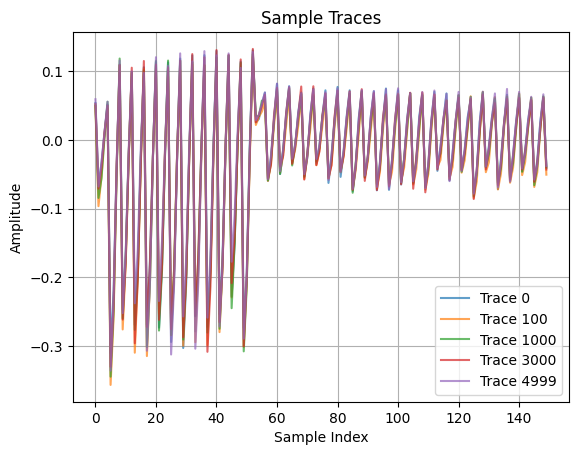

In [44]:
# multiple traces

for i in [0, 100, 1000, 3000, 4999]:  # Adjust if fewer traces
    plt.plot(data['wave'][i], alpha=0.7, label=f"Trace {i}")
plt.title("Sample Traces")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
data = np.load(r"C:\Users\Ahmed\Desktop\AdvSecLab\traces\traces_0.npz", allow_pickle=True)
print("Keys in .npz:", list(data.keys()))


Keys in .npz: ['wave', 'dut_io_data', 'dut_io_computed_data']


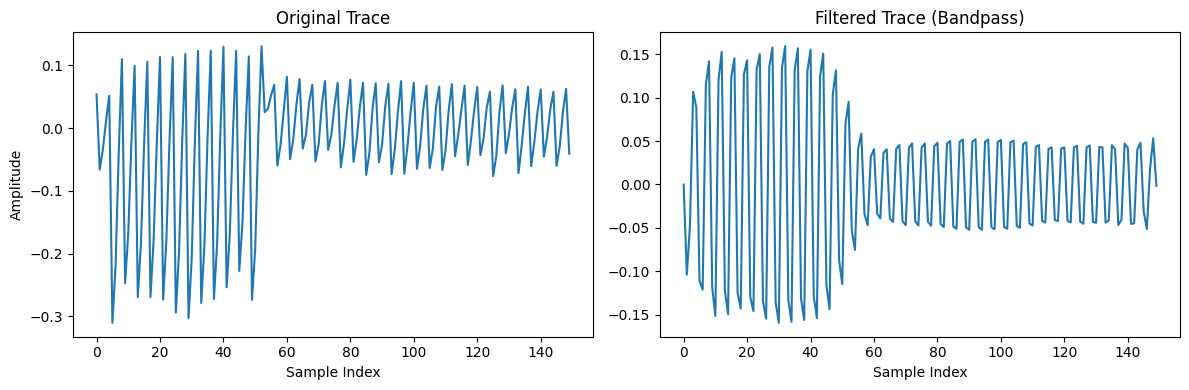

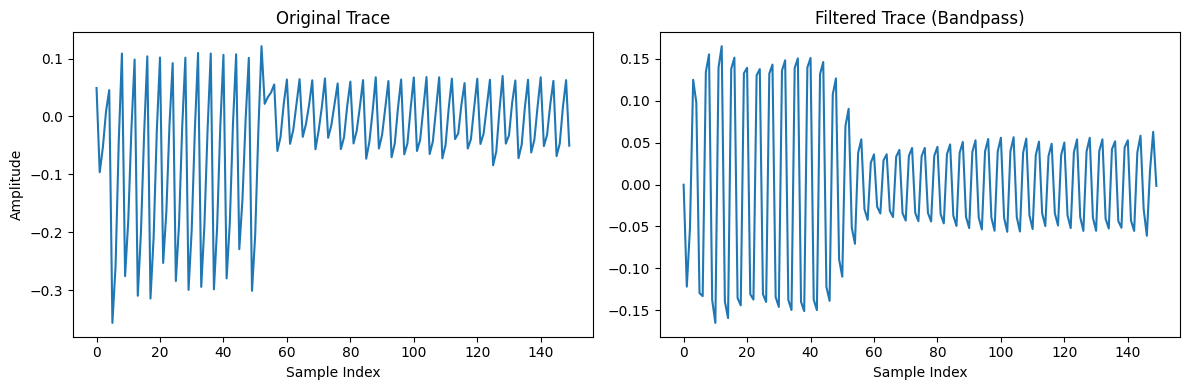

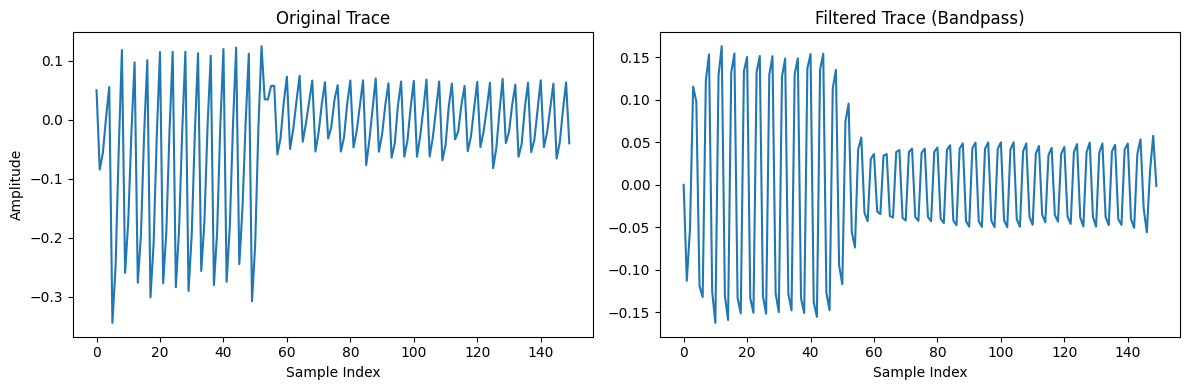

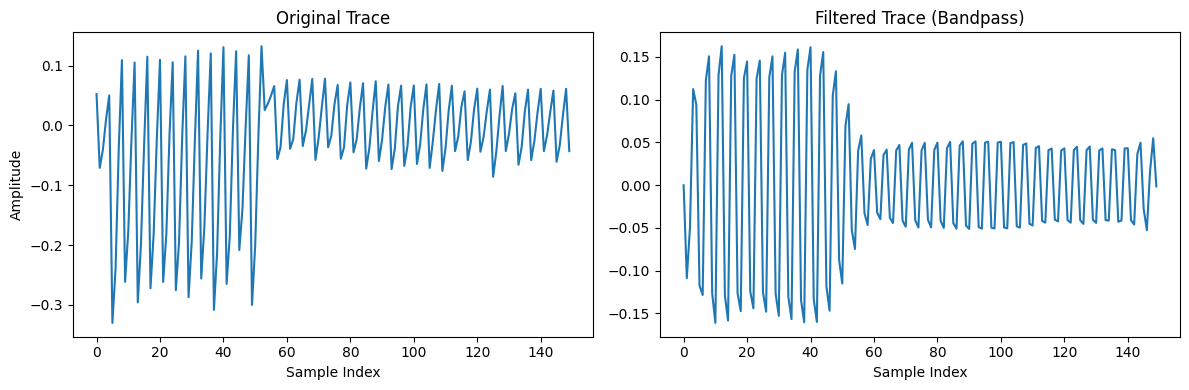

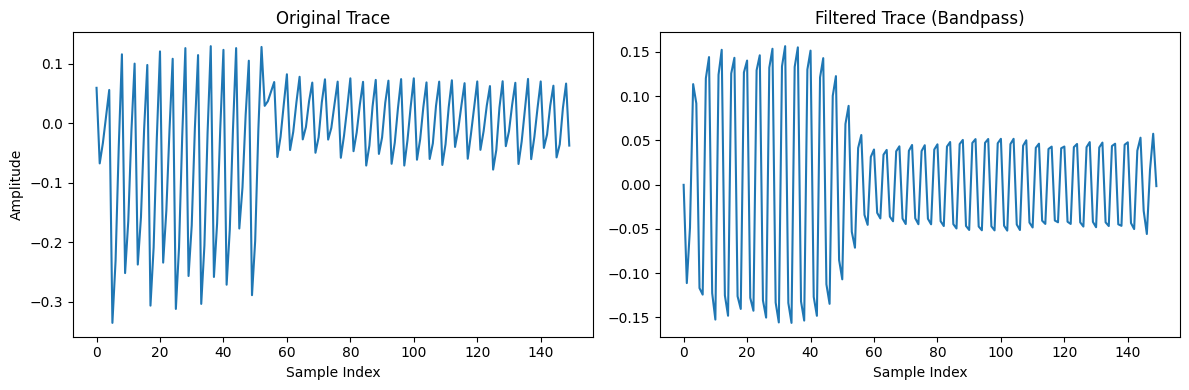

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define the bandpass filter
def bandpass_filter(trace, lowcut=20e6, highcut=30e6, fs=100e6, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, trace)

# Load the .npz file
traces = data['wave']
dut_io_data = data['dut_io_data']
dut_io_computed_data = data['dut_io_computed_data']

# Apply the filter to all traces
filtered_traces = np.array([bandpass_filter(trace) for trace in traces])

# Plot one example trace (before and after filtering)

example_index = 0
for example_index in [0, 100, 1000, 3000, 4999]:
    original = traces[example_index]
    filtered = filtered_traces[example_index]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title("Original Trace")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")

    plt.subplot(1, 2, 2)
    plt.plot(filtered)
    plt.title("Filtered Trace (Bandpass)")
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()

# Save filtered traces to a new file
np.savez_compressed(
    'data/traces_1_filtered.npz',
    wave=filtered_traces,
    dut_io_data=dut_io_data,
    dut_io_computed_data=dut_io_computed_data
)


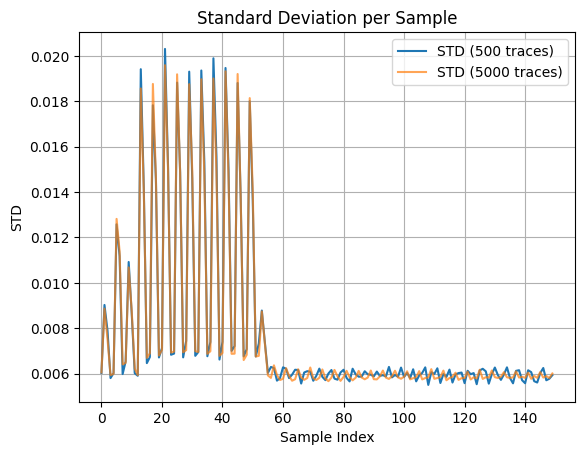

In [47]:
waves_500 = np.array([trace for trace in traces[:500]])
waves_5000 = np.array([trace for trace in traces[:5000]])

std_500 = np.std(waves_500, axis=0)
std_5000 = np.std(waves_5000, axis=0)

plt.plot(std_500, label='STD (500 traces)')
plt.plot(std_5000, label='STD (5000 traces)', alpha=0.7)
plt.title("Standard Deviation per Sample")
plt.xlabel("Sample Index")
plt.ylabel("STD")
plt.legend()
plt.grid(True)
plt.show()



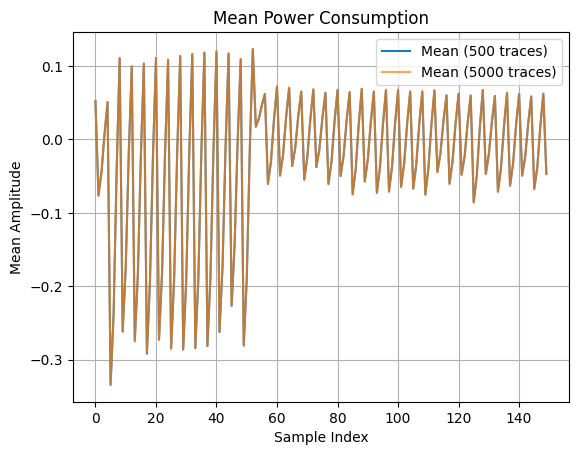

In [48]:
mean_500 = np.mean(waves_500, axis=0)
mean_5000 = np.mean(waves_5000, axis=0)

plt.plot(mean_500, label="Mean (500 traces)")
plt.plot(mean_5000, label="Mean (5000 traces)", alpha=0.7)
plt.title("Mean Power Consumption")
plt.xlabel("Sample Index")
plt.ylabel("Mean Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
mean_traces_5000 = np.mean(waves_5000, axis=1)
zero_like = np.where(np.abs(mean_traces_5000) < 1e-6)[0]
print(f"Number of zero-like traces in 5000: {len(zero_like)}")


Number of zero-like traces in 5000: 0


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from dtaidistance import dtw


# Load original data
traces = data['wave']
dut_io_data = data['dut_io_data']
dut_io_computed_data = data['dut_io_computed_data']

# Enhanced preprocessing pipeline   
def preprocess_trace(trace, fs=100e6):
    # DC offset removal
    trace = trace - np.mean(trace)
    
    # Moving average smoothing
    window = 5
    trace = np.convolve(trace, np.ones(window)/window, 'same')
    
    # Bandpass filter
    nyq = 0.5 * fs
    b, a = butter(4, [20e6/nyq, 30e6/nyq], btype='band')
    trace = filtfilt(b, a, trace)
    
    # Savitzky-Golay derivative filter
    return savgol_filter(trace, 21, 2)

# Apply preprocessing
filtered_traces = np.array([preprocess_trace(trace) for trace in traces])

# Dynamic Time Warping alignment
def align_traces(traces, ref_idx=0, window_size=30):
    reference = traces[ref_idx]
    aligned = [reference]
    
    # Find reference peak in region of interest
    roi = reference[20:120]
    ref_peak = 20 + np.argmax(np.abs(roi))
    
    for i in range(len(traces)):
        if i == ref_idx:
            continue
            
        trace = traces[i]
        # Focus on search window around reference peak
        start = max(0, ref_peak - window_size)
        end = min(len(trace), ref_peak + window_size)
        search_region = trace[start:end]
        
        # Compute cross-correlation
        corr = correlate(reference[start:end], search_region, mode='same')
        lag = np.argmax(corr) - window_size
        
        # Apply shift
        if lag > 0:
            aligned_trace = np.concatenate([trace[lag:], np.zeros(lag)])
        elif lag < 0:
            aligned_trace = np.concatenate([np.zeros(-lag), trace[:lag]])
        else:
            aligned_trace = trace
            
        aligned.append(aligned_trace)
    
    return np.array(aligned)

aligned_traces = align_traces(filtered_traces)


# Save enhanced dataset
np.savez_compressed(
    'data/traces_1_enhanced.npz',
    wave=aligned_traces,
    dut_io_data = data['dut_io_data'],
    dut_io_computed_data = data['dut_io_computed_data'],
    metadata={
        'processing': 'DC_remove+MA+bandpass+SG+DTW+feature_extract+PCA',
        'fs': 100e6,
        'bandpass': [20e6, 30e6]
    },

)

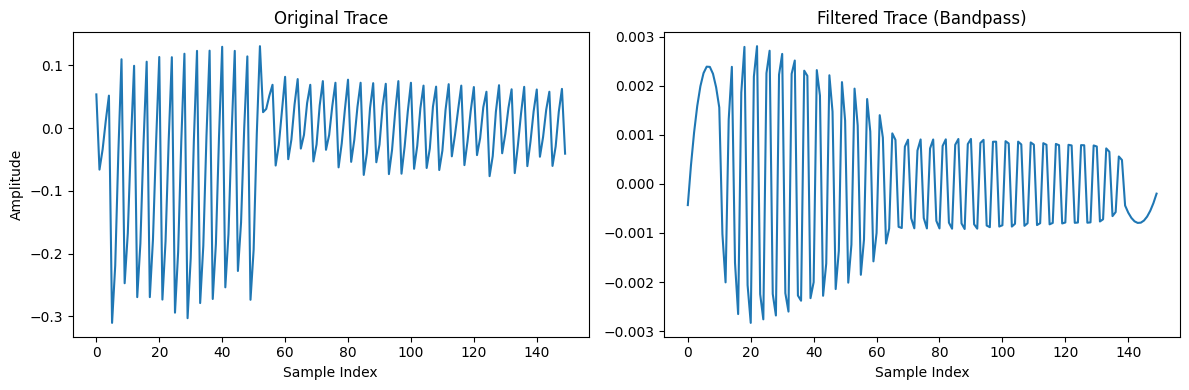

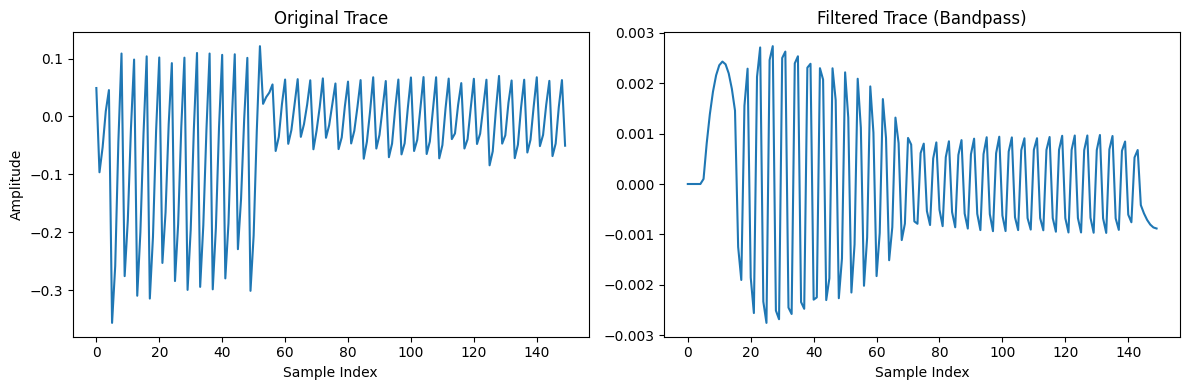

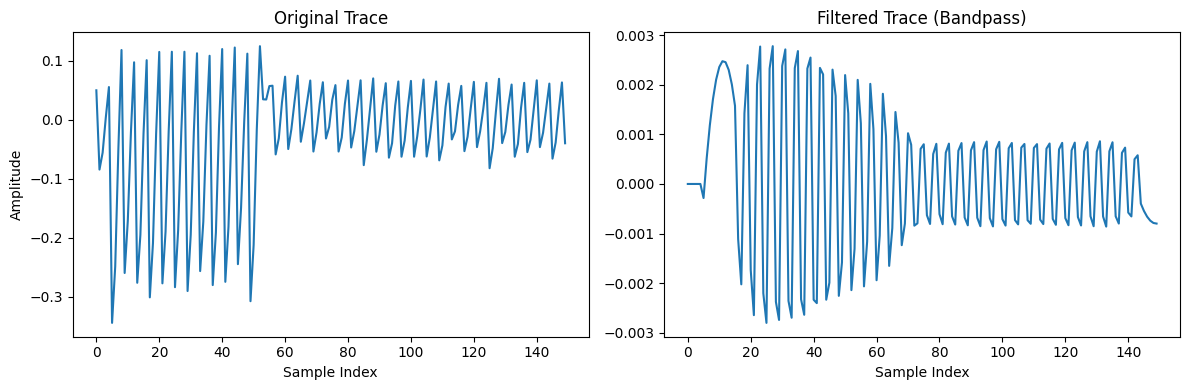

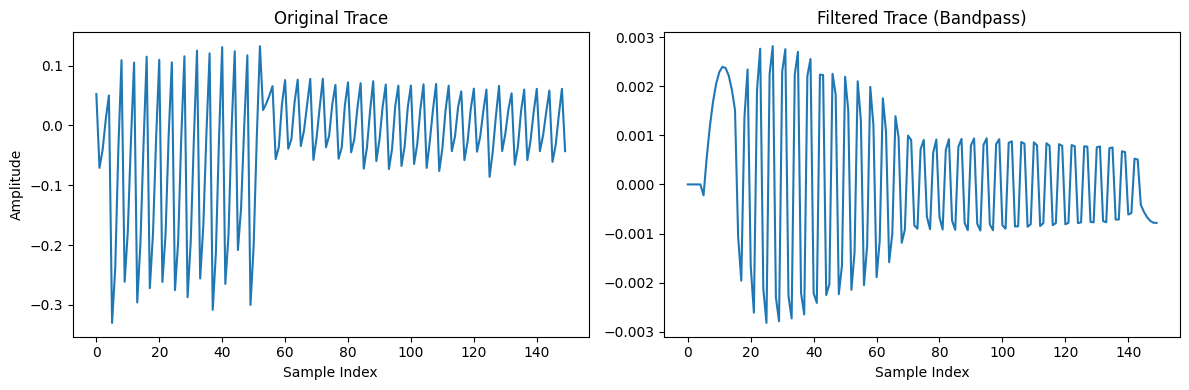

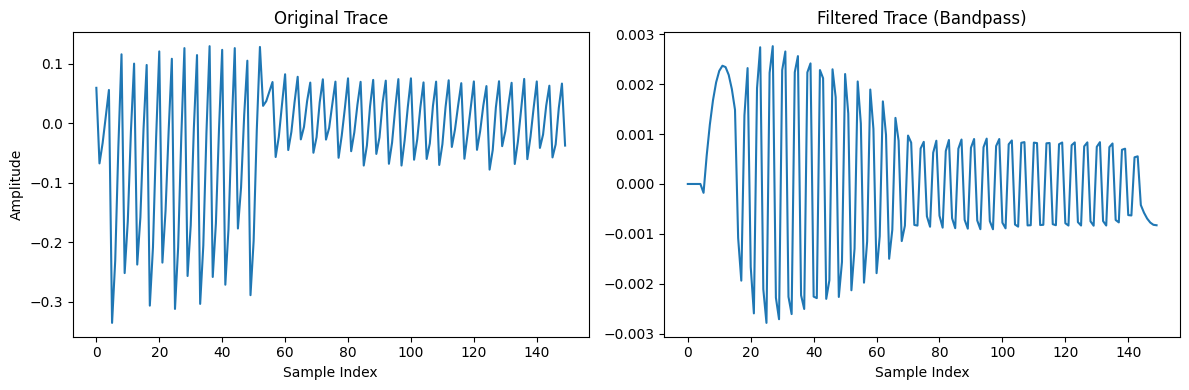

In [ ]:
example_index = 0
data = np.load(r'C:\Users\Ahmed\Desktop\AdvSecLab\advseceng25-sca-framework-main\src\py\data\traces_1_enhanced.npz')
enhanced_traces = data['wave']
for example_index in [0, 100, 1000, 3000, 4999]:
    original = traces[example_index]
    filtered = enhanced_traces[example_index]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title("Original Trace")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")

    plt.subplot(1, 2, 2)
    plt.plot(filtered)
    plt.title("Filtered Trace (Bandpass)")
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()